# Vivino Wine Analysis

## Project Overview

### Dataset Generation and Construction

Our initial approach was to search for existing wine datasets suitable for analyzing wine quality and characteristics. However, after reviewing available public datasets—such as the **UCI Wine Quality dataset**—we found they were not aligned with our analytical goals. These datasets typically focus on **physicochemical properties** (fixed acidity, volatile acidity, pH, sulphates, etc.) from a scientific perspective, but lack critical **market-driven and consumer-oriented information** such as:

- Price
- Country of origin
- Grape varieties
- Aromatic profiles

Since **Vivino** is the leading reference platform for wine ratings and encompasses a comprehensive range of consumer preferences and wine characteristics, we decided to **generate our own dataset** by scraping data through the Vivino API. This approach allowed us to selectively extract the specific variables most relevant to our analysis:

- Sensory characteristics (acidity, intensity, sweetness, tannin)
- User ratings
- Grape varieties
- Country of origin
- Price ranges
- Aromatic profiles (flavor ranks)

---

## Analysis Workflow

This notebook follows a structured approach to wine quality prediction:

1. **Data Exploratory Analysis & Unsupervised Exploration**: Understanding the data distribution, correlations, and potential natural groupings
2. **Data Preprocessing**: Cleaning the data, handling missing values, encoding categorical variables, and preparing train/test splits
3. **Baseline Modeling**: Establishing baseline results using Linear Regression and Ensemble methods (Random Forest)

---

## Data Schema

| Column | Type | Description |
|--------|------|-------------|
| `id` | Integer | Unique identifier |
| `name` | String | Wine name |
| `vintage` | Integer | Vintage year |
| `country` | String | Country of origin |
| `winery` | String | Winery name |
| `grapes` | String | Semicolon-separated grape varieties |
| `rating` | Float | Vivino average rating (target variable) |
| `price` | Float | Price in local currency |
| `acidity` | Float | Normalized acidity score |
| `intensity` | Float | Normalized intensity score |
| `sweetness` | Float | Normalized sweetness score |
| `tannin` | Float | Normalized tannin score |
| `flavor_rank1` | String | Primary flavor category |
| `flavor_rank2` | String | Secondary flavor category |
| `flavor_rank3` | String | Tertiary flavor category |

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [13]:
# Load and initial data cleaning
df = pd.read_csv('data/all_wines.csv')

print(f"Initial dataset shape: {df.shape}")
print(f"\nFirst look at the data:")
display(df.head(10))

# Data cleaning
initial_rows = df.shape[0]

# Remove duplicates
df = df.drop_duplicates()
print(f"\n✓ Removed {initial_rows - df.shape[0]} duplicate rows")

# Drop rows without ratings or with rating = 0 (target variable)
df = df.dropna(subset=['rating'])
df = df[df['rating'] > 0]
print(f"✓ Removed rows with missing or zero ratings")

print(f"\nCleaned dataset shape: {df.shape}")
print(f"\n{'='*60}")
print("Dataset Information:")
print(f"{'='*60}")
df.info()

Initial dataset shape: (24440, 15)

First look at the data:


,id,name,vintage,country,winery,grapes,rating,price,acidity,intensity,sweetness,tannin,flavor_rank1,flavor_rank2,flavor_rank3
0,1232441,Château Roquefort Bordeaux Rouge 2008,2008,France,Château Roquefort,Cabernet Sauvignon;Cabernet franc;Malbec;Merlo...,3.7,5.00,3.779062,3.958017,1.510457,3.602762,black_fruit,earth,oak
1,1196114,Nadau Château Gillet Bordeaux Rouge 2019,2019,France,Nadau,Cabernet Sauvignon;Cabernet franc;Malbec;Merlo...,3.5,4.90,3.672749,3.710543,1.473961,3.512615,black_fruit,oak,red_fruit
2,1222364,Château Gravelier Bordeaux Rouge 2022,2022,France,Château Gravelier,Cabernet Sauvignon;Cabernet franc;Malbec;Merlo...,3.4,4.90,3.847436,3.892167,1.678449,3.283518,red_fruit,oak,black_fruit
3,1195299,Les Hauts de Palette Château Haut-Mondain Bord...,2016,France,Les Hauts de Palette,Cabernet Sauvignon;Cabernet franc;Malbec;Merlo...,3.4,4.90,3.627296,3.664513,1.638803,3.364282,oak,black_fruit,spices
4,1183224,Château des Léotins Bordeaux Rouge 2023,2023,France,Château des Léotins,Cabernet Sauvignon;Cabernet franc;Malbec;Merlo...,3.3,4.50,3.876773,3.579522,1.343426,3.439363,black_fruit,oak,earth
5,1313410,Les Hauts de Palette Chateau du Barail Bordeau...,2024,France,Les Hauts de Palette,Cabernet Sauvignon;Cabernet franc;Malbec;Merlo...,3.3,3.60,3.808670,3.921041,1.143353,3.903815,oak,citrus_fruit,red_fruit
6,1145198,Lafleur Chevalier Bordeaux 2020,2020,France,Lafleur Chevalier,Cabernet Sauvignon;Cabernet franc;Malbec;Merlo...,3.3,5.00,3.968939,4.000000,1.892576,3.968939,black_fruit,spices,NaN
7,13624987,RNB - Romain Balmigere Syrah 2024,2024,France,RNB - Romain Balmigere,Syrah;Grenache;Mourvèdre,0.0,3.95,4.000000,4.000000,1.000000,4.000000,NaN,NaN,NaN
8,1383709,Mongeard-Mugneret Richebourg Grand Cru 1993,1993,France,Mongeard-Mugneret,Pinot Noir,4.5,1.00,4.052714,3.122222,2.028138,2.598734,red_fruit,oak,earth
9,84732,Domaine des Lambrays Clos des Lambrays Grand C...,1943,France,Domaine des Lambrays,Pinot Noir,4.4,1.00,4.169805,2.977007,1.744701,2.657177,red_fruit,earth,oak



✓ Removed 0 duplicate rows
✓ Removed rows with missing or zero ratings

Cleaned dataset shape: (23506, 15)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 23506 entries, 0 to 24439
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            23506 non-null  int64  
 1   name          23506 non-null  object 
 2   vintage       23504 non-null  object 
 3   country       23506 non-null  object 
 4   winery        23504 non-null  object 
 5   grapes        21575 non-null  object 
 6   rating        23506 non-null  float64
 7   price         23506 non-null  float64
 8   acidity       23346 non-null  float64
 9   intensity     23346 non-null  float64
 10  sweetness     23346 non-null  float64
 11  tannin        23342 non-null  float64
 12  flavor_rank1  21953 non-null  object 
 13  flavor_rank2  21491 non-null  object 
 14  flavor_rank3  21060 non-null  object 
dtypes: float64(6), int64(1), objec

---

# 1. Data Exploratory Analysis & Unsupervised Exploration

In this section, we will:
- Understand the distribution of key variables (rating, price, sensory characteristics)
- Explore relationships between features through correlation analysis
- Identify natural groupings using unsupervised learning techniques (K-Means clustering, PCA)
- Analyze wine characteristics across different countries and grape varieties

## 1.1 Descriptive Statistics

In [14]:
# Summary statistics for numeric variables
print("="*60)
print("DESCRIPTIVE STATISTICS")
print("="*60)
display(df.describe().round(1))

# Missing values analysis
print("\n" + "="*60)
print("MISSING VALUES ANALYSIS")
print("="*60)
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
display(missing_data)

# Value counts for key categorical variables
print("\n" + "="*60)
print("TOP 10 COUNTRIES")
print("="*60)
print(df['country'].value_counts().head(10))

print("France only right now")

print("\n" + "="*60)
print("TOP 10 GRAPE VARIETIES (most common first grape)")
print("="*60)
df['first_grape'] = df['grapes'].fillna('Unknown').str.split(';').str[0]
print(df['first_grape'].value_counts().head(10))

DESCRIPTIVE STATISTICS


,id,rating,price,acidity,intensity,sweetness,tannin
count,23506.0,23506.0,23506.0,23346.0,23346.0,23346.0,23342.0
mean,2768399.3,3.9,26.0,3.8,3.5,1.6,3.3
std,2758092.2,0.2,12.8,0.4,0.8,0.3,0.7
min,1058.0,2.6,1.0,2.2,1.0,1.0,1.2
25%,1174765.0,3.8,15.0,3.4,3.0,1.4,2.9
50%,1571556.0,3.9,24.0,3.8,3.8,1.5,3.4
75%,3435881.5,4.1,36.0,4.1,4.1,1.7,3.8
max,13435341.0,4.7,56.2,5.0,5.0,3.1,5.0



MISSING VALUES ANALYSIS


,Column,Missing_Count,Missing_Percentage
flavor_rank3,flavor_rank3,2446,10.41
flavor_rank2,flavor_rank2,2015,8.57
grapes,grapes,1931,8.21
flavor_rank1,flavor_rank1,1553,6.61
tannin,tannin,164,0.70
acidity,acidity,160,0.68
intensity,intensity,160,0.68
sweetness,sweetness,160,0.68
vintage,vintage,2,0.01
winery,winery,2,0.01



TOP 10 COUNTRIES
country
France    23506
Name: count, dtype: int64
France only right now

TOP 10 GRAPE VARIETIES (most common first grape)
first_grape
Cabernet Sauvignon    7826
Syrah                 7044
Pinot Noir            3941
Unknown               1931
Gamay                 1338
Cabernet franc        1024
Malbec                 261
Grenache               141
Name: count, dtype: int64


## 1.2 Distribution Analysis

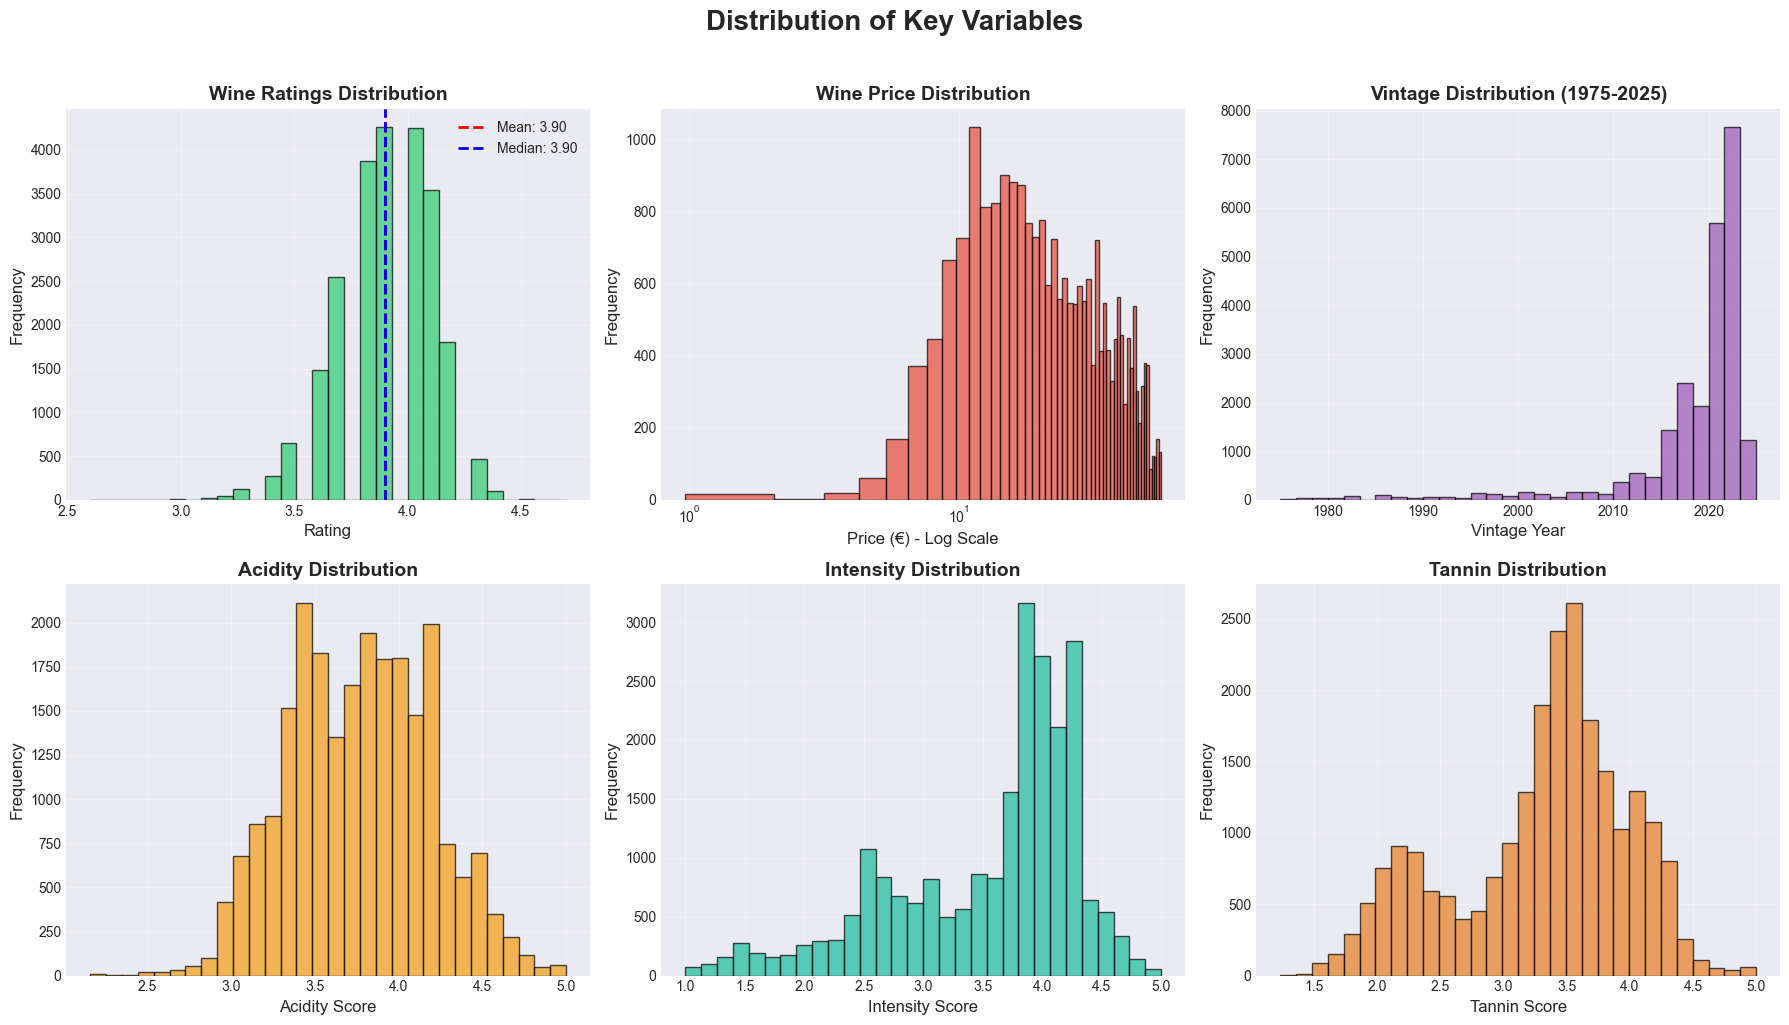

In [15]:
# Distribution visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution of Key Variables', fontsize=20, fontweight='bold', y=1.02)

# 1. Rating Distribution
axes[0, 0].hist(df['rating'], bins=30, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(df['rating'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["rating"].mean():.2f}')
axes[0, 0].axvline(df['rating'].median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {df["rating"].median():.2f}')
axes[0, 0].set_xlabel('Rating', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Wine Ratings Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Price Distribution (Log Scale)
price_clean = df[df['price'] > 0]['price']
axes[0, 1].hist(price_clean, bins=50, color='#e74c3c', alpha=0.7, edgecolor='black')
axes[0, 1].set_xscale('log')
axes[0, 1].set_xlabel('Price (€) - Log Scale', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Wine Price Distribution', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 3. Vintage Distribution (last 50 years)
# Convert vintage to numeric first, handling non-numeric values
df_vintage_numeric = pd.to_numeric(df['vintage'], errors='coerce')
vintage_clean = df_vintage_numeric[(df_vintage_numeric >= 1975) & (df_vintage_numeric <= 2025)]
axes[0, 2].hist(vintage_clean.dropna(), bins=30, color='#9b59b6', alpha=0.7, edgecolor='black')
axes[0, 2].set_xlabel('Vintage Year', fontsize=12)
axes[0, 2].set_ylabel('Frequency', fontsize=12)
axes[0, 2].set_title('Vintage Distribution (1975-2025)', fontsize=14, fontweight='bold')
axes[0, 2].grid(alpha=0.3)

# 4. Acidity Distribution
acidity_clean = df.dropna(subset=['acidity'])['acidity']
axes[1, 0].hist(acidity_clean, bins=30, color='#f39c12', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Acidity Score', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Acidity Distribution', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 5. Intensity Distribution
intensity_clean = df.dropna(subset=['intensity'])['intensity']
axes[1, 1].hist(intensity_clean, bins=30, color='#1abc9c', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Intensity Score', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Intensity Distribution', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

# 6. Tannin Distribution
tannin_clean = df.dropna(subset=['tannin'])['tannin']
axes[1, 2].hist(tannin_clean, bins=30, color='#e67e22', alpha=0.7, edgecolor='black')
axes[1, 2].set_xlabel('Tannin Score', fontsize=12)
axes[1, 2].set_ylabel('Frequency', fontsize=12)
axes[1, 2].set_title('Tannin Distribution', fontsize=14, fontweight='bold')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 1.3 Relationship Analysis

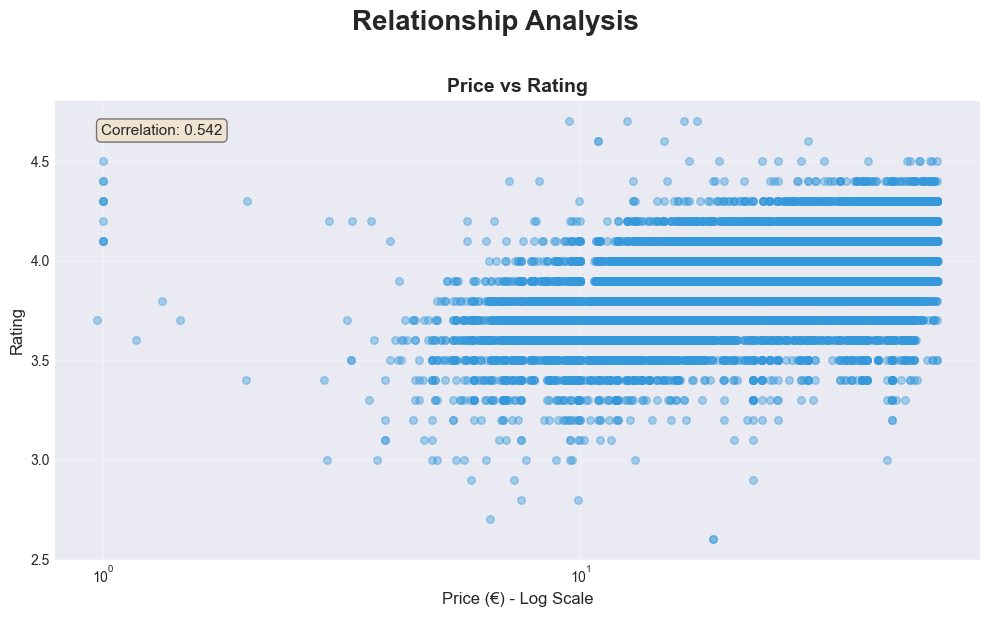

In [40]:
# Key relationship visualizations
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Relationship Analysis', fontsize=20, fontweight='bold', y=1.02)

# Price vs Rating
price_rating = df[(df['price'] > 0) & (df['price'] < 500)]  # Filter outliers for better viz
axes.scatter(price_rating['price'], price_rating['rating'], alpha=0.4, s=30, color='#3498db')
axes.set_xscale('log')
axes.set_xlabel('Price (€) - Log Scale', fontsize=12)
axes.set_ylabel('Rating', fontsize=12)
axes.set_title('Price vs Rating', fontsize=14, fontweight='bold')
axes.grid(alpha=0.3)

# Add trend line
from scipy.stats import pearsonr
valid_data = price_rating[['price', 'rating']].dropna()
if len(valid_data) > 0:
    corr, p_value = pearsonr(np.log10(valid_data['price']), valid_data['rating'])
    axes.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=axes.transAxes, 
             fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# # 2. Top 10 Countries by Average Rating
# top_countries = df.groupby('country').agg({
#     'rating': 'mean',
#     'id': 'count'
# }).rename(columns={'id': 'count'}).sort_values('rating', ascending=False).head(10)
# top_countries = top_countries[top_countries['count'] >= 20]  # At least 20 wines

# axes[1].barh(range(len(top_countries)), top_countries['rating'], color='#2ecc71', alpha=0.7)
# axes[1].set_yticks(range(len(top_countries)))
# axes[1].set_yticklabels(top_countries.index)
# axes[1].set_xlabel('Average Rating', fontsize=12)
# axes[1].set_title('Top 10 Countries by Average Rating\n(min. 20 wines)', fontsize=14, fontweight='bold')
# axes[1].grid(alpha=0.3, axis='x')
# axes[1].invert_yaxis()

# # 3. Price distribution by Top 5 Countries
# top_5_countries = df['country'].value_counts().head(5).index
# price_by_country = df[df['country'].isin(top_5_countries) & (df['price'] > 0) & (df['price'] < 200)]

# axes[2].violinplot([price_by_country[price_by_country['country'] == country]['price'].values 
#                      for country in top_5_countries], 
#                     showmeans=True, showmedians=True)
# axes[2].set_xticks(range(1, len(top_5_countries) + 1))
# axes[2].set_xticklabels(top_5_countries, rotation=45)
# axes[2].set_ylabel('Price (€)', fontsize=12)
# axes[2].set_title('Price Distribution by Top 5 Countries', fontsize=14, fontweight='bold')
# axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 1.4 Correlation Analysis

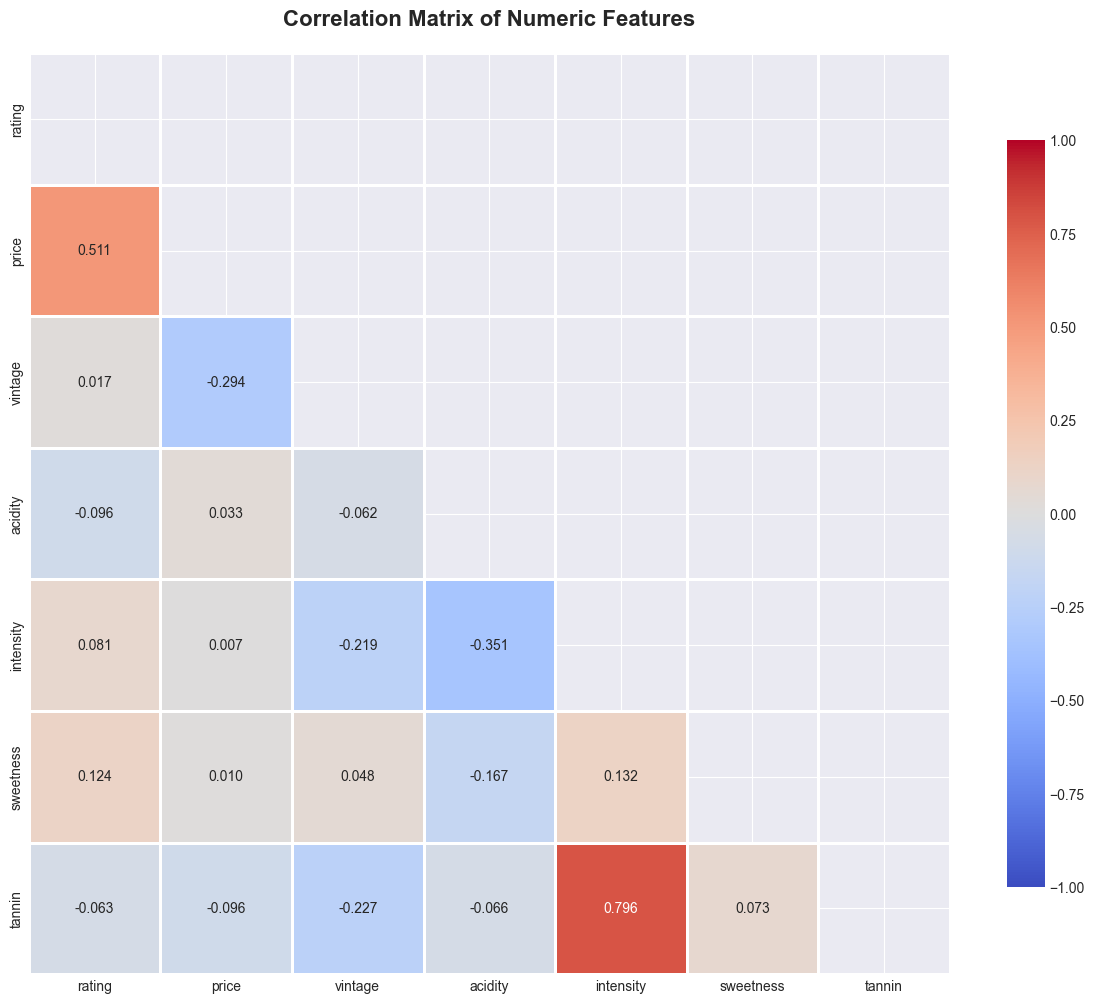

KEY CORRELATIONS WITH RATING
price          : +0.5109
sweetness      : +0.1238
intensity      : +0.0809
vintage        : +0.0172
tannin         : -0.0633
acidity        : -0.0960


In [17]:
# Correlation matrix for numeric features
numeric_features = ['rating', 'price', 'vintage', 'acidity', 'intensity', 'sweetness', 'tannin']

# Create a copy and convert vintage to numeric
df_corr = df[numeric_features].copy()
df_corr['vintage'] = pd.to_numeric(df_corr['vintage'], errors='coerce')

# Drop rows with any missing values
correlation_data = df_corr.dropna()

# Compute correlation matrix
corr_matrix = correlation_data.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numeric Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print key correlations with rating
print("="*60)
print("KEY CORRELATIONS WITH RATING")
print("="*60)
rating_corr = corr_matrix['rating'].sort_values(ascending=False)
for feature, corr_value in rating_corr.items():
    if feature != 'rating':
        print(f"{feature:15s}: {corr_value:+.4f}")

## 1.5 Unsupervised Learning: K-Means Clustering

We will apply K-Means clustering to identify natural groupings of wines based on their characteristics. This can reveal distinct wine profiles beyond traditional categorizations.

In [18]:
# Prepare data for clustering
cluster_features = ['price', 'rating', 'acidity', 'intensity', 'sweetness', 'tannin']
X_cluster = df[cluster_features].copy()

# Impute missing values with median
imputer = SimpleImputer(strategy='median')
X_cluster_imputed = imputer.fit_transform(X_cluster)

# Standardize features (critical for K-Means)
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster_imputed)

print("✓ Data prepared for clustering")
print(f"  Shape: {X_cluster_scaled.shape}")
print(f"  Features: {cluster_features}")

✓ Data prepared for clustering
  Shape: (23506, 6)
  Features: ['price', 'rating', 'acidity', 'intensity', 'sweetness', 'tannin']


Computing optimal K...
✓ Completed
✓ Completed


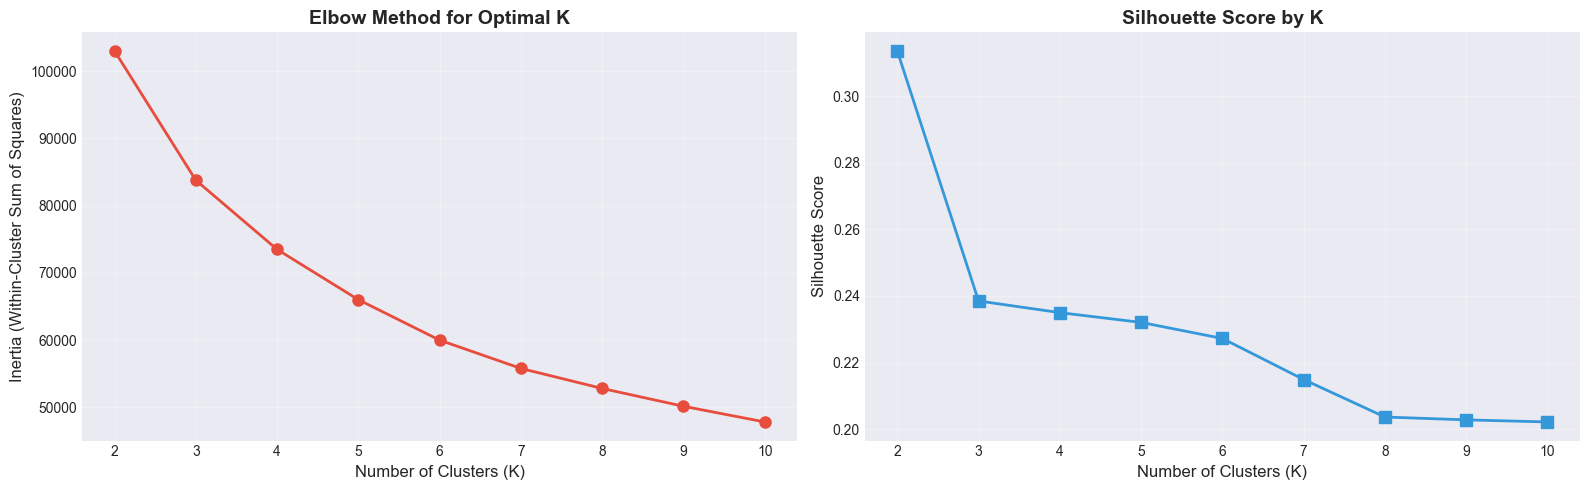


✓ Optimal K based on Silhouette Score: 2
  Silhouette Score: 0.3136


In [19]:
# Determine optimal number of clusters using Elbow Method
inertia_values = []
silhouette_scores = []
K_range = range(2, 11)

from sklearn.metrics import silhouette_score

print("Computing optimal K...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster_scaled, kmeans.labels_))
    
print("✓ Completed")

# Plot Elbow curve and Silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Elbow plot
axes[0].plot(K_range, inertia_values, marker='o', linewidth=2, markersize=8, color='#e74c3c')
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].set_xticks(K_range)

# Silhouette plot
axes[1].plot(K_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='#3498db')
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score by K', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].set_xticks(K_range)

plt.tight_layout()
plt.show()

# Find optimal K (highest silhouette score)
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n✓ Optimal K based on Silhouette Score: {optimal_k}")
print(f"  Silhouette Score: {max(silhouette_scores):.4f}")

In [36]:
# Apply K-Means with optimal K
k_final = 3  # Using 3 clusters for interpretability
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_cluster_scaled)

# Add cluster labels to original dataframe
df['cluster'] = cluster_labels

print(f"✓ K-Means clustering completed with K={k_final}")
print(f"\nCluster distribution:")
print(df['cluster'].value_counts().sort_index())

✓ K-Means clustering completed with K=3

Cluster distribution:
cluster
0    8317
1    9753
2    5436
Name: count, dtype: int64


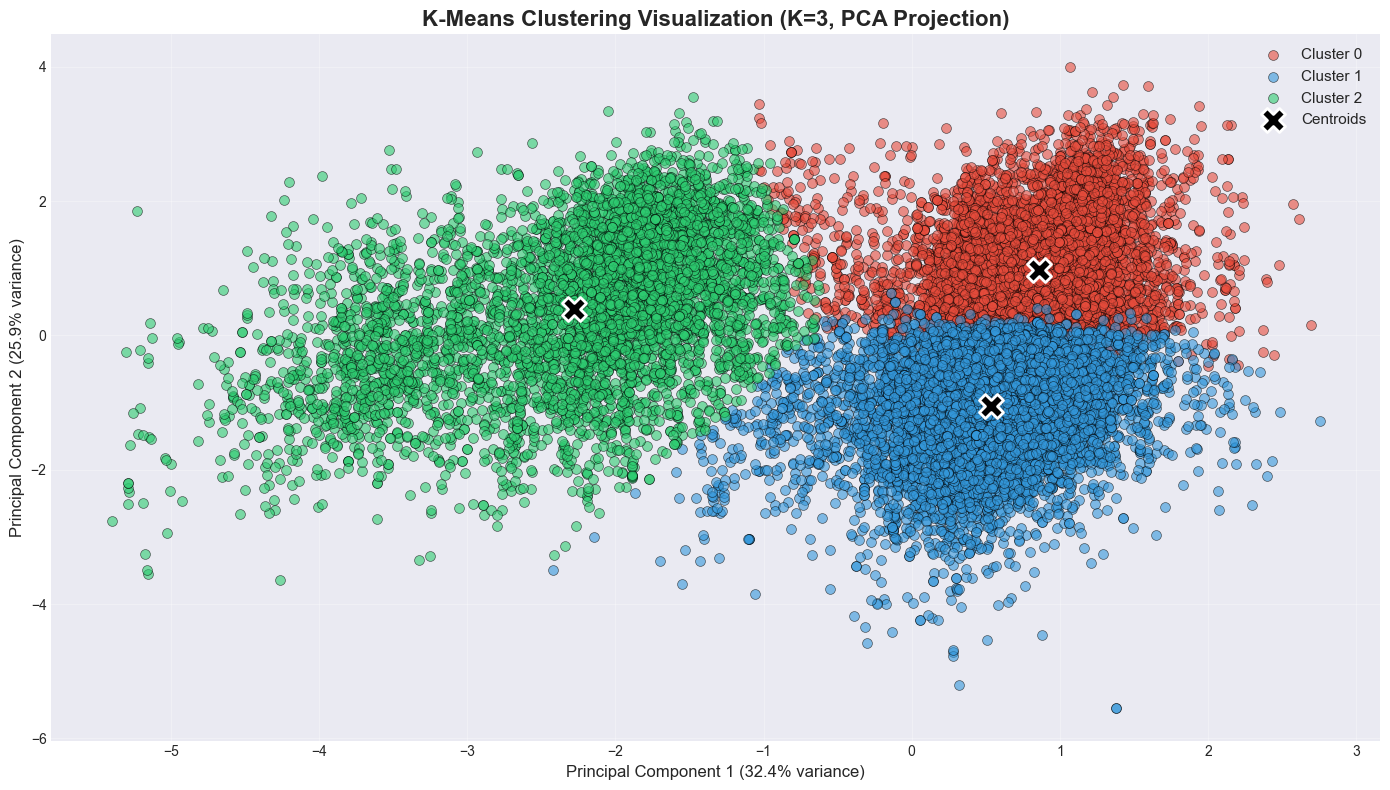

✓ Explained variance by first 2 PCs: 58.25%


In [37]:
# Visualize clusters using PCA (2D projection)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

# Create PCA dataframe
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = cluster_labels

# Plot
plt.figure(figsize=(14, 8))
colors = ['#e74c3c', '#3498db', '#2ecc71']
for i in range(k_final):
    cluster_data = pca_df[pca_df['cluster'] == i]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], 
                c=colors[i], label=f'Cluster {i}', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

# Plot cluster centers
centers_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
            c='black', marker='X', s=300, linewidths=2, edgecolors='white', 
            label='Centroids', zorder=5)

plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
plt.title(f'K-Means Clustering Visualization (K={k_final}, PCA Projection)', fontsize=16, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✓ Explained variance by first 2 PCs: {sum(pca.explained_variance_ratio_)*100:.2f}%")

CLUSTER CHARACTERISTICS (Mean Values)


,price,rating,acidity,intensity,sweetness,tannin
cluster,,,,,,
0,34.874800,4.049729,3.635861,4.023960,1.626650,3.608145
1,15.832048,3.761653,3.700473,3.810006,1.545260,3.612973
2,30.467463,3.927704,4.080108,2.358154,1.450324,2.271662


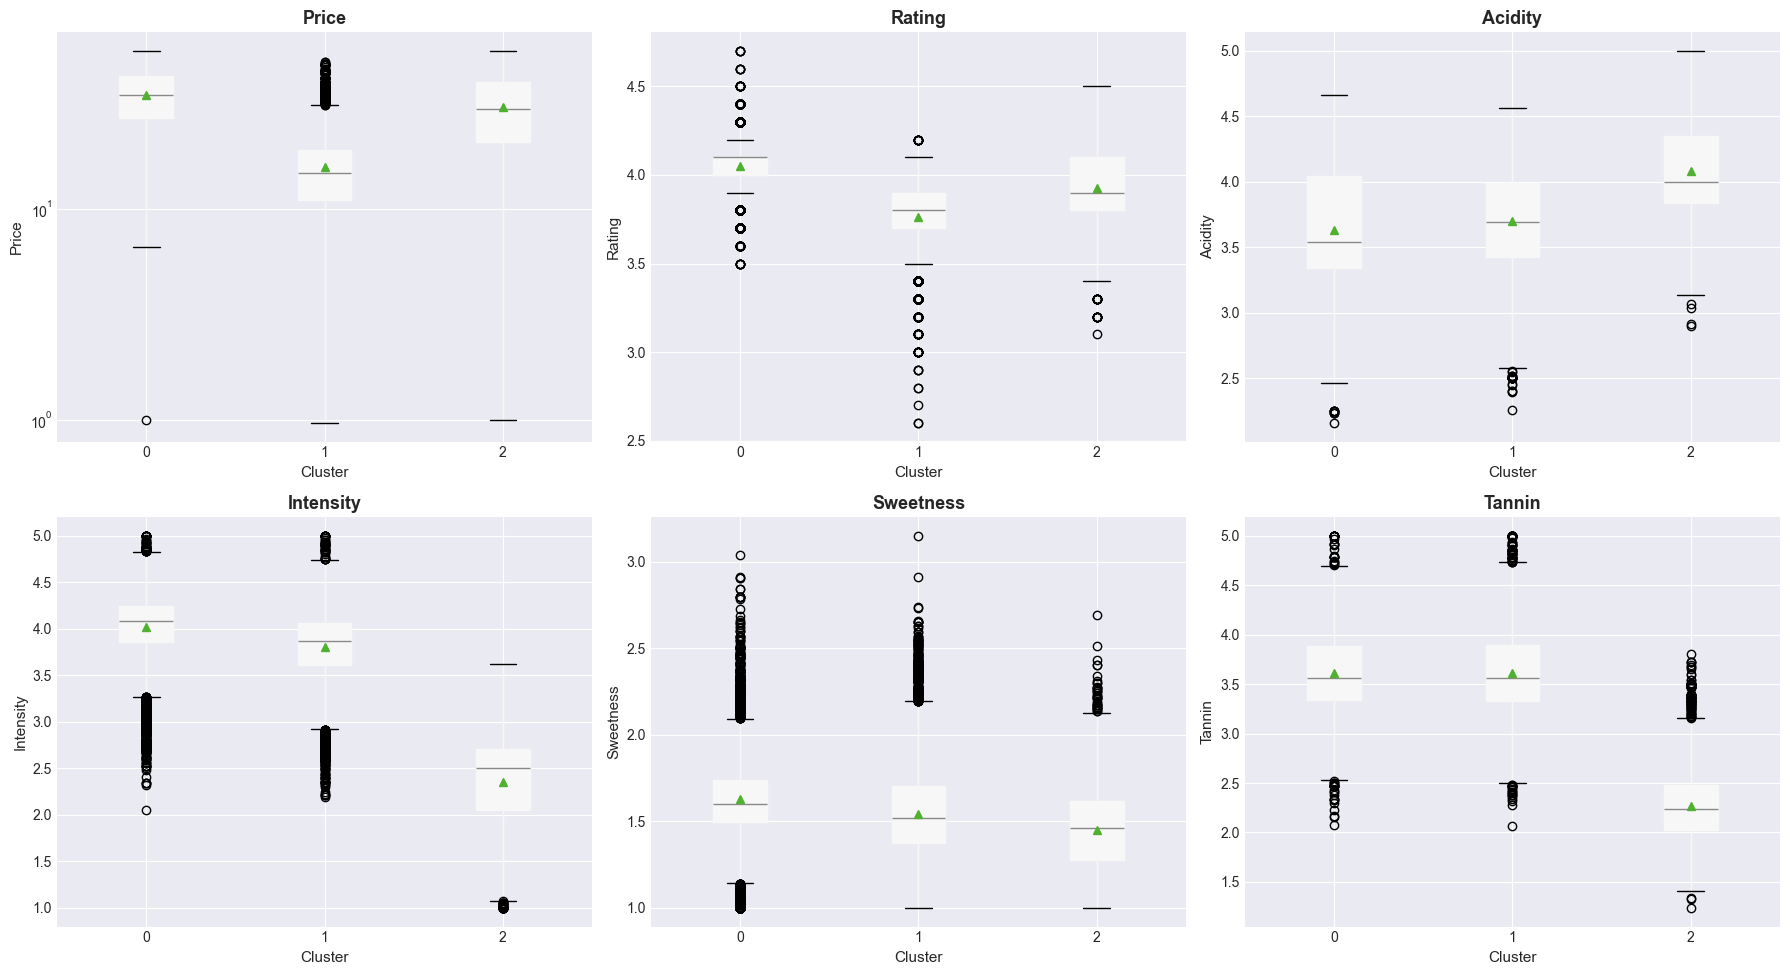


CLUSTER INTERPRETATION

Cluster 0 (8317 wines):
   • Average Rating: 4.05
   • Average Price: €34.87
   • Acidity: 3.64 | Intensity: 4.02
   • Sweetness: 1.63 | Tannin: 3.61

Cluster 1 (9753 wines):
   • Average Rating: 3.76
   • Average Price: €15.83
   • Acidity: 3.70 | Intensity: 3.81
   • Sweetness: 1.55 | Tannin: 3.61

Cluster 2 (5436 wines):
   • Average Rating: 3.93
   • Average Price: €30.47
   • Acidity: 4.08 | Intensity: 2.36
   • Sweetness: 1.45 | Tannin: 2.27


In [41]:
# Analyze cluster characteristics
print("="*80)
print("CLUSTER CHARACTERISTICS (Mean Values)")
print("="*80)

cluster_summary = df.groupby('cluster')[cluster_features].mean()
display(cluster_summary)

# Visualize cluster characteristics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Cluster Characteristics Comparison', fontsize=18, fontweight='bold', y=1.00)

for idx, feature in enumerate(cluster_features):
    row = idx // 3
    col = idx % 3
    
    df.boxplot(column=feature, by='cluster', ax=axes[row, col], 
               patch_artist=True, showmeans=True)
    axes[row, col].set_title(f'{feature.capitalize()}', fontsize=13, fontweight='bold')
    axes[row, col].set_xlabel('Cluster', fontsize=11)
    axes[row, col].set_ylabel(feature.capitalize(), fontsize=11)
    axes[row, col].get_figure().suptitle('')  # Remove default title
    
    # Log scale for price
    if feature == 'price':
        axes[row, col].set_yscale('log')

plt.tight_layout()
plt.show()

# Describe clusters in words
print("\n" + "="*80)
print("CLUSTER INTERPRETATION")
print("="*80)
for cluster_id in range(k_final):
    cluster_data = cluster_summary.loc[cluster_id]
    print(f"\nCluster {cluster_id} ({len(df[df['cluster'] == cluster_id])} wines):")
    print(f"   • Average Rating: {cluster_data['rating']:.2f}")
    print(f"   • Average Price: €{cluster_data['price']:.2f}")
    print(f"   • Acidity: {cluster_data['acidity']:.2f} | Intensity: {cluster_data['intensity']:.2f}")
    print(f"   • Sweetness: {cluster_data['sweetness']:.2f} | Tannin: {cluster_data['tannin']:.2f}")

---

# 2. Data Preprocessing

In this section, we will:
- Handle missing values appropriately
- Encode categorical variables (country, winery, flavor ranks)
- Process the grape varieties using text vectorization
- Engineer new features (e.g., wine age from vintage)
- Create preprocessing pipelines
- Split data into training and testing sets

The goal is to prepare clean, properly formatted data for our predictive models.

In [42]:
# Prepare features and target
# Remove cluster column if it exists (from EDA)
if 'cluster' in df.columns:
    df_model = df.drop(['cluster', 'first_grape'], axis=1, errors='ignore')
else:
    df_model = df.copy()

# Separate features and target
X = df_model.drop(['rating', 'id', 'name'], axis=1)
y = df_model['rating']

print("="*60)
print("DATA PREPARATION")
print("="*60)
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures: {list(X.columns)}")

# Convert vintage to numeric (handle 'N.V.' entries)
X['vintage'] = pd.to_numeric(X['vintage'], errors='coerce')

# Engineer age feature
current_year = 2025
X['age'] = current_year - X['vintage']
X['age'] = X['age'].clip(lower=0)  # No negative ages

print(f"\n✓ Created 'age' feature from vintage")

DATA PREPARATION
Features shape: (23506, 12)
Target shape: (23506,)

Features: ['vintage', 'country', 'winery', 'grapes', 'price', 'acidity', 'intensity', 'sweetness', 'tannin', 'flavor_rank1', 'flavor_rank2', 'flavor_rank3']

✓ Created 'age' feature from vintage


In [24]:
# Define feature groups for preprocessing pipelines
numeric_features = ['vintage', 'price', 'acidity', 'intensity', 'sweetness', 'tannin', 'age']
categorical_features = ['country', 'winery', 'flavor_rank1', 'flavor_rank2', 'flavor_rank3']
text_feature = ['grapes']  # Special handling for grape varieties

print("="*60)
print("FEATURE GROUPS")
print("="*60)
print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"Text features ({len(text_feature)}): {text_feature}")

FEATURE GROUPS
Numeric features (7): ['vintage', 'price', 'acidity', 'intensity', 'sweetness', 'tannin', 'age']
Categorical features (5): ['country', 'winery', 'flavor_rank1', 'flavor_rank2', 'flavor_rank3']
Text features (1): ['grapes']


In [25]:
# Create preprocessing transformers

# 1. Numeric transformer: Impute missing values with median + Standardize
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Categorical transformer: Impute missing + One-Hot Encode (limit to top 20 categories)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, max_categories=20))
])

# 3. Grape varieties transformer: Custom tokenization + Binary vectorization
def split_semicolon(text):
    """Split grape varieties by semicolon"""
    if pd.isna(text) or text == '':
        return []
    return [x.strip() for x in str(text).split(';')]

grapes_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('flatten', FunctionTransformer(lambda x: np.reshape(x, -1), feature_names_out='one-to-one')),
    ('vectorizer', CountVectorizer(
        tokenizer=split_semicolon, 
        token_pattern=None, 
        binary=True,
        max_features=50  # Limit to top 50 grape varieties
    ))
])

print("✓ Preprocessing transformers created")

✓ Preprocessing transformers created


In [26]:
# Combine all transformers into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('grapes', grapes_transformer, text_feature)
    ],
    remainder='drop'  # Drop any remaining columns
)

print("✓ Complete preprocessor pipeline created")
print(f"\n  → Numeric features: {len(numeric_features)}")
print(f"  → Categorical features: {len(categorical_features)}")
print(f"  → Text features: {len(text_feature)}")

✓ Complete preprocessor pipeline created

  → Numeric features: 7
  → Categorical features: 5
  → Text features: 1


In [27]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=pd.cut(y, bins=5, labels=False)  # Stratify by rating bins for balanced split
)

print("="*60)
print("TRAIN-TEST SPLIT")
print("="*60)
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Testing set:  {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTarget distribution in train set:")
print(y_train.describe())
print(f"\nTarget distribution in test set:")
print(y_test.describe())

TRAIN-TEST SPLIT
Training set: 18804 samples (80.0%)
Testing set:  4702 samples (20.0%)

Target distribution in train set:
count    18804.000000
mean         3.902430
std          0.206911
min          2.600000
25%          3.800000
50%          3.900000
75%          4.100000
max          4.700000
Name: rating, dtype: float64

Target distribution in test set:
count    4702.000000
mean        3.900191
std         0.204174
min         2.800000
25%         3.800000
50%         3.900000
75%         4.000000
max         4.500000
Name: rating, dtype: float64


In [28]:
# Apply preprocessing transformations
print("Applying preprocessing transformations...")
print("(This may take a moment for large datasets)")

# Fit on training data only (to prevent data leakage)
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print("\n" + "="*60)
print("PREPROCESSING COMPLETE")
print("="*60)
print(f"✓ Training features shape: {X_train_transformed.shape}")
print(f"✓ Testing features shape:  {X_test_transformed.shape}")

# Get feature names
try:
    feature_names = preprocessor.get_feature_names_out()
    print(f"\n✓ Total features after preprocessing: {len(feature_names)}")
    
    # Count features by type
    num_count = sum(1 for f in feature_names if f.startswith('num__'))
    cat_count = sum(1 for f in feature_names if f.startswith('cat__'))
    grape_count = sum(1 for f in feature_names if f.startswith('grapes__'))
    
    print(f"  → Numeric features: {num_count}")
    print(f"  → Categorical features: {cat_count}")
    print(f"  → Grape features: {grape_count}")
    
    # Show sample grape features
    grape_features = [f for f in feature_names if f.startswith('grapes__')][:10]
    print(f"\n  Sample grape features: {[f.replace('grapes__', '') for f in grape_features]}")
    
except Exception as e:
    print(f"\nNote: Could not extract feature names ({e})")

Applying preprocessing transformations...
(This may take a moment for large datasets)

PREPROCESSING COMPLETE
✓ Training features shape: (18804, 97)
✓ Testing features shape:  (4702, 97)

✓ Total features after preprocessing: 97
  → Numeric features: 7
  → Categorical features: 63
  → Grape features: 27

  Sample grape features: ['cabernet franc', 'cabernet sauvignon', 'carignan', 'carménère', 'cinsaut', 'counoise', 'côt', 'fer servadou', 'gamay', 'grenache']

PREPROCESSING COMPLETE
✓ Training features shape: (18804, 97)
✓ Testing features shape:  (4702, 97)

✓ Total features after preprocessing: 97
  → Numeric features: 7
  → Categorical features: 63
  → Grape features: 27

  Sample grape features: ['cabernet franc', 'cabernet sauvignon', 'carignan', 'carménère', 'cinsaut', 'counoise', 'côt', 'fer servadou', 'gamay', 'grenache']


---

# 3. Baseline Modeling

In this section, we will establish baseline performance using three approaches:
1. **Linear Regression**: Simple linear model to understand basic relationships
2. **Random Forest**: Ensemble method that can capture non-linear patterns
3. **Gradient Boosting**: Sequential ensemble method that builds trees iteratively to correct errors

We will evaluate models using:
- **RMSE** (Root Mean Squared Error): Average prediction error
- **MAE** (Mean Absolute Error): Average absolute prediction error
- **R²** (R-squared): Proportion of variance explained by the model

## 3.1 Linear Regression

In [29]:
# Train Linear Regression model
print("Training Linear Regression model...")
lr_model = LinearRegression()
lr_model.fit(X_train_transformed, y_train)
print("✓ Model trained")

# Make predictions
y_pred_lr_train = lr_model.predict(X_train_transformed)
y_pred_lr_test = lr_model.predict(X_test_transformed)

# Evaluate on training set
rmse_lr_train = np.sqrt(mean_squared_error(y_train, y_pred_lr_train))
mae_lr_train = mean_absolute_error(y_train, y_pred_lr_train)
r2_lr_train = r2_score(y_train, y_pred_lr_train)

# Evaluate on test set
rmse_lr_test = np.sqrt(mean_squared_error(y_test, y_pred_lr_test))
mae_lr_test = mean_absolute_error(y_test, y_pred_lr_test)
r2_lr_test = r2_score(y_test, y_pred_lr_test)

# Display results
print("\n" + "="*60)
print("LINEAR REGRESSION RESULTS")
print("="*60)
print(f"\n{'Metric':<20} {'Train':>12} {'Test':>12}")
print("-" * 60)
print(f"{'RMSE':<20} {rmse_lr_train:>12.4f} {rmse_lr_test:>12.4f}")
print(f"{'MAE':<20} {mae_lr_train:>12.4f} {mae_lr_test:>12.4f}")
print(f"{'R² Score':<20} {r2_lr_train:>12.4f} {r2_lr_test:>12.4f}")
print("="*60)

Training Linear Regression model...
✓ Model trained

LINEAR REGRESSION RESULTS

Metric                      Train         Test
------------------------------------------------------------
RMSE                       0.1653       0.1635
MAE                        0.1272       0.1261
R² Score                   0.3620       0.3583


## 3.2 Random Forest

In [30]:
# Train Random Forest model
print("Training Random Forest model...")
print("(This may take a few minutes depending on dataset size)")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,  # Use all CPU cores
    verbose=0
)
rf_model.fit(X_train_transformed, y_train)
print("✓ Model trained")

# Make predictions
y_pred_rf_train = rf_model.predict(X_train_transformed)
y_pred_rf_test = rf_model.predict(X_test_transformed)

# Evaluate on training set
rmse_rf_train = np.sqrt(mean_squared_error(y_train, y_pred_rf_train))
mae_rf_train = mean_absolute_error(y_train, y_pred_rf_train)
r2_rf_train = r2_score(y_train, y_pred_rf_train)

# Evaluate on test set
rmse_rf_test = np.sqrt(mean_squared_error(y_test, y_pred_rf_test))
mae_rf_test = mean_absolute_error(y_test, y_pred_rf_test)
r2_rf_test = r2_score(y_test, y_pred_rf_test)

# Display results
print("\n" + "="*60)
print("RANDOM FOREST RESULTS")
print("="*60)
print(f"\n{'Metric':<20} {'Train':>12} {'Test':>12}")
print("-" * 60)
print(f"{'RMSE':<20} {rmse_rf_train:>12.4f} {rmse_rf_test:>12.4f}")
print(f"{'MAE':<20} {mae_rf_train:>12.4f} {mae_rf_test:>12.4f}")
print(f"{'R² Score':<20} {r2_rf_train:>12.4f} {r2_rf_test:>12.4f}")
print("="*60)

Training Random Forest model...
(This may take a few minutes depending on dataset size)
✓ Model trained

RANDOM FOREST RESULTS

Metric                      Train         Test
------------------------------------------------------------
RMSE                       0.1034       0.1465
MAE                        0.0766       0.1120
R² Score                   0.7505       0.4852
✓ Model trained

RANDOM FOREST RESULTS

Metric                      Train         Test
------------------------------------------------------------
RMSE                       0.1034       0.1465
MAE                        0.0766       0.1120
R² Score                   0.7505       0.4852


## 3.3 Gradient Boosting

In [31]:
# Train Gradient Boosting model
from sklearn.ensemble import GradientBoostingRegressor

print("Training Gradient Boosting model...")
print("(This may take a few minutes depending on dataset size)")

gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,
    random_state=42,
    verbose=0
)
gb_model.fit(X_train_transformed, y_train)
print("✓ Model trained")

# Make predictions
y_pred_gb_train = gb_model.predict(X_train_transformed)
y_pred_gb_test = gb_model.predict(X_test_transformed)

# Evaluate on training set
rmse_gb_train = np.sqrt(mean_squared_error(y_train, y_pred_gb_train))
mae_gb_train = mean_absolute_error(y_train, y_pred_gb_train)
r2_gb_train = r2_score(y_train, y_pred_gb_train)

# Evaluate on test set
rmse_gb_test = np.sqrt(mean_squared_error(y_test, y_pred_gb_test))
mae_gb_test = mean_absolute_error(y_test, y_pred_gb_test)
r2_gb_test = r2_score(y_test, y_pred_gb_test)

# Display results
print("\n" + "="*60)
print("GRADIENT BOOSTING RESULTS")
print("="*60)
print(f"\n{'Metric':<20} {'Train':>12} {'Test':>12}")
print("-" * 60)
print(f"{'RMSE':<20} {rmse_gb_train:>12.4f} {rmse_gb_test:>12.4f}")
print(f"{'MAE':<20} {mae_gb_train:>12.4f} {mae_gb_test:>12.4f}")
print(f"{'R² Score':<20} {r2_gb_train:>12.4f} {r2_gb_test:>12.4f}")
print("="*60)

Training Gradient Boosting model...
(This may take a few minutes depending on dataset size)
✓ Model trained

GRADIENT BOOSTING RESULTS

Metric                      Train         Test
------------------------------------------------------------
RMSE                       0.1418       0.1495
MAE                        0.1097       0.1158
R² Score                   0.5302       0.4635
✓ Model trained

GRADIENT BOOSTING RESULTS

Metric                      Train         Test
------------------------------------------------------------
RMSE                       0.1418       0.1495
MAE                        0.1097       0.1158
R² Score                   0.5302       0.4635


## 3.4 Model Comparison

MODEL COMPARISON SUMMARY


,Model,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R²,Test R²
0,Linear Regression,0.165271,0.163543,0.127203,0.126055,0.361956,0.358266
1,Random Forest,0.103359,0.146475,0.076616,0.112000,0.750452,0.485222
2,Gradient Boosting,0.141810,0.149530,0.109729,0.115764,0.530246,0.463526


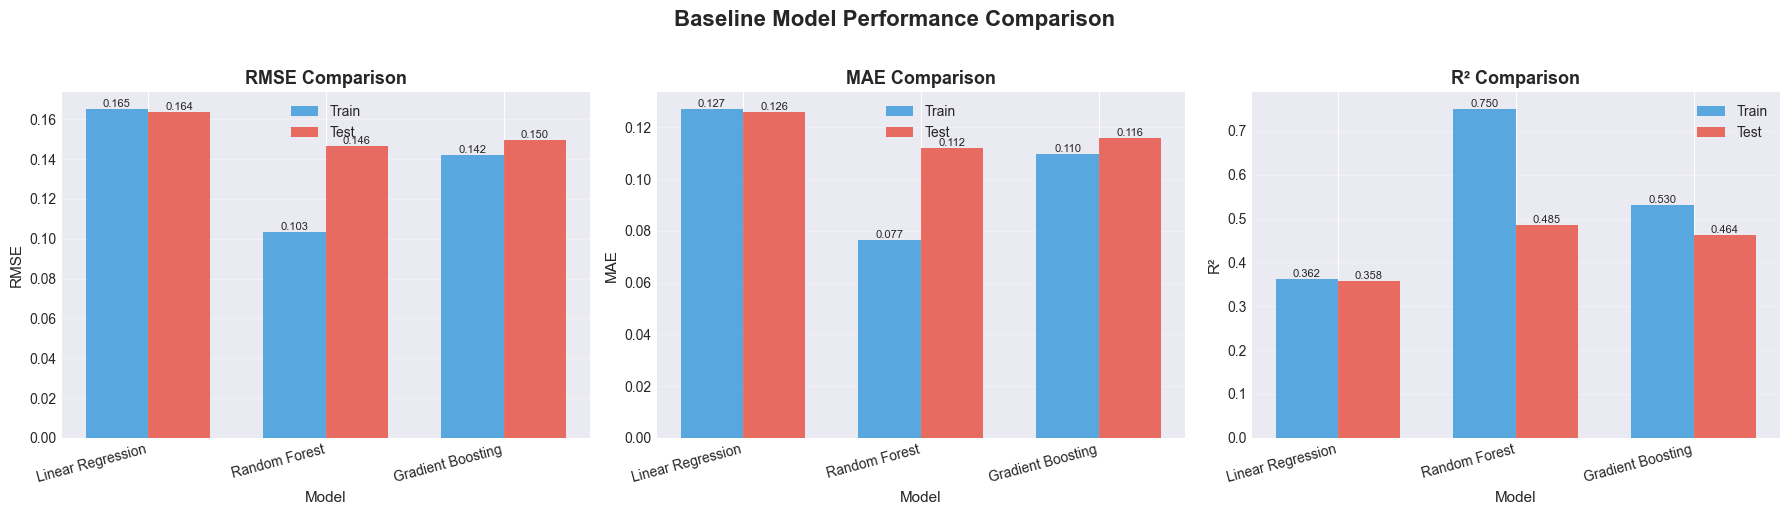


🏆 Best performing model (by Test R²): Random Forest


In [ ]:
# Compare models side-by-side
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'Train RMSE': [rmse_lr_train, rmse_rf_train, rmse_gb_train],
    'Test RMSE': [rmse_lr_test, rmse_rf_test, rmse_gb_test],
    'Train MAE': [mae_lr_train, mae_rf_train, mae_gb_train],
    'Test MAE': [mae_lr_test, mae_rf_test, mae_gb_test],
    'Train R²': [r2_lr_train, r2_rf_train, r2_gb_train],
    'Test R²': [r2_lr_test, r2_rf_test, r2_gb_test]
})

print("="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
display(comparison_df)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Baseline Model Performance Comparison', fontsize=16, fontweight='bold', y=1.02)

metrics = ['RMSE', 'MAE', 'R²']
train_data = [[rmse_lr_train, rmse_rf_train, rmse_gb_train], 
              [mae_lr_train, mae_rf_train, mae_gb_train], 
              [r2_lr_train, r2_rf_train, r2_gb_train]]
test_data = [[rmse_lr_test, rmse_rf_test, rmse_gb_test], 
             [mae_lr_test, mae_rf_test, mae_gb_test], 
             [r2_lr_test, r2_rf_test, r2_gb_test]]

for idx, (metric, train_vals, test_vals) in enumerate(zip(metrics, train_data, test_data)):
    x = np.arange(len(comparison_df['Model']))
    width = 0.35
    
    axes[idx].bar(x - width/2, train_vals, width, label='Train', alpha=0.8, color='#3498db')
    axes[idx].bar(x + width/2, test_vals, width, label='Test', alpha=0.8, color='#e74c3c')
    
    axes[idx].set_xlabel('Model', fontsize=11)
    axes[idx].set_ylabel(metric, fontsize=11)
    axes[idx].set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (train_val, test_val) in enumerate(zip(train_vals, test_vals)):
        axes[idx].text(i - width/2, train_val, f'{train_val:.3f}', 
                      ha='center', va='bottom', fontsize=8)
        axes[idx].text(i + width/2, test_val, f'{test_val:.3f}', 
                      ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Determine best model
best_r2_scores = [('Linear Regression', r2_lr_test), ('Random Forest', r2_rf_test), ('Gradient Boosting', r2_gb_test)]
best_model_name = max(best_r2_scores, key=lambda x: x[1])[0]
print(f"\nBest performing model (by Test R²): {best_model_name}")

## 3.5 Prediction Visualization

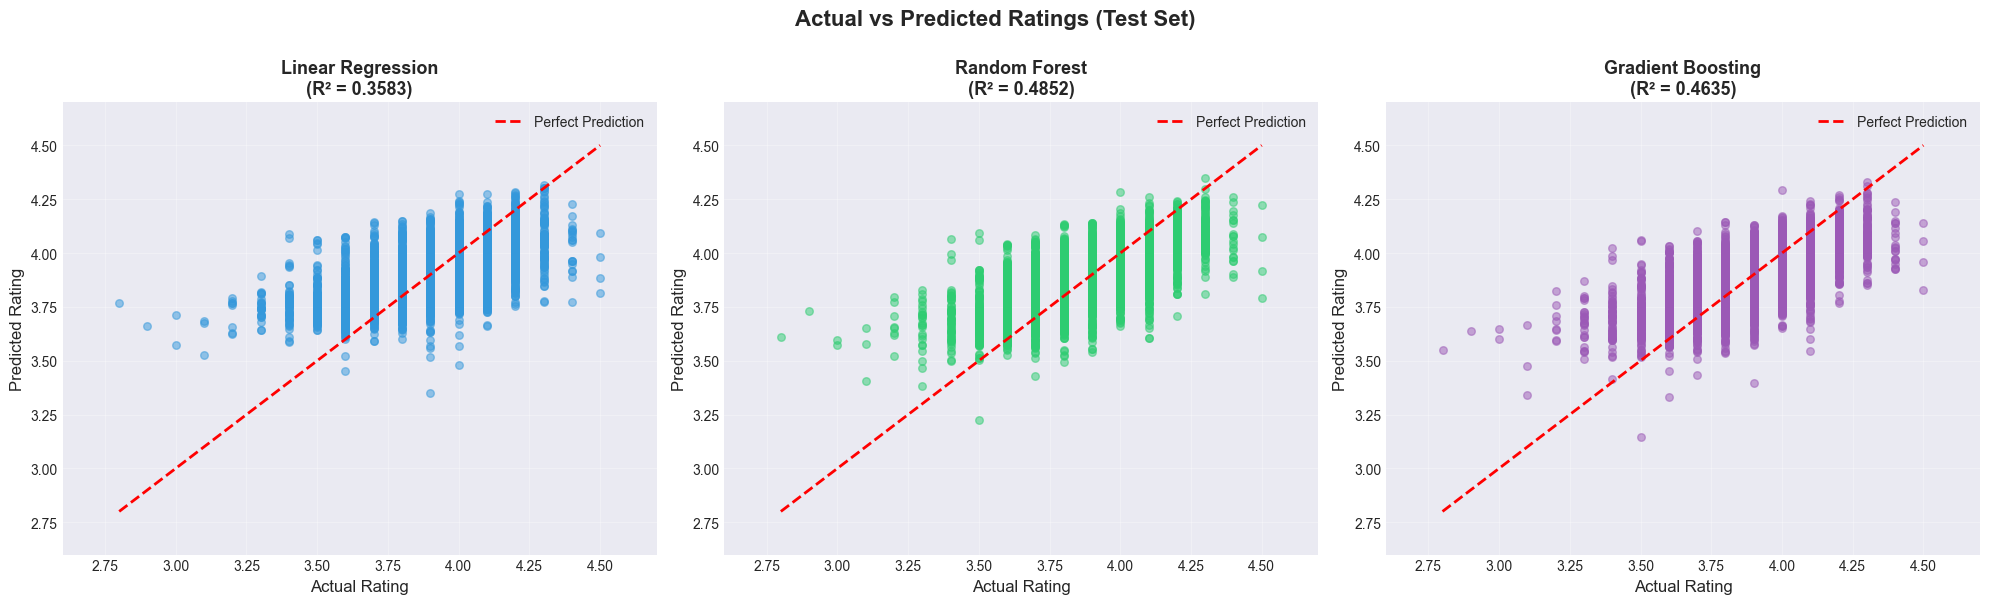

In [33]:
# Actual vs Predicted plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Actual vs Predicted Ratings (Test Set)', fontsize=16, fontweight='bold', y=1.00)

models = [
    ('Linear Regression', y_pred_lr_test, r2_lr_test, '#3498db'),
    ('Random Forest', y_pred_rf_test, r2_rf_test, '#2ecc71'),
    ('Gradient Boosting', y_pred_gb_test, r2_gb_test, '#9b59b6')
]

for idx, (name, y_pred, r2, color) in enumerate(models):
    axes[idx].scatter(y_test, y_pred, alpha=0.5, s=30, color=color)
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                   'r--', lw=2, label='Perfect Prediction')
    axes[idx].set_xlabel('Actual Rating', fontsize=12)
    axes[idx].set_ylabel('Predicted Rating', fontsize=12)
    axes[idx].set_title(f'{name}\n(R² = {r2:.4f})', fontsize=13, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)
    axes[idx].set_xlim([y_test.min() - 0.2, y_test.max() + 0.2])
    axes[idx].set_ylim([y_test.min() - 0.2, y_test.max() + 0.2])

plt.tight_layout()
plt.show()

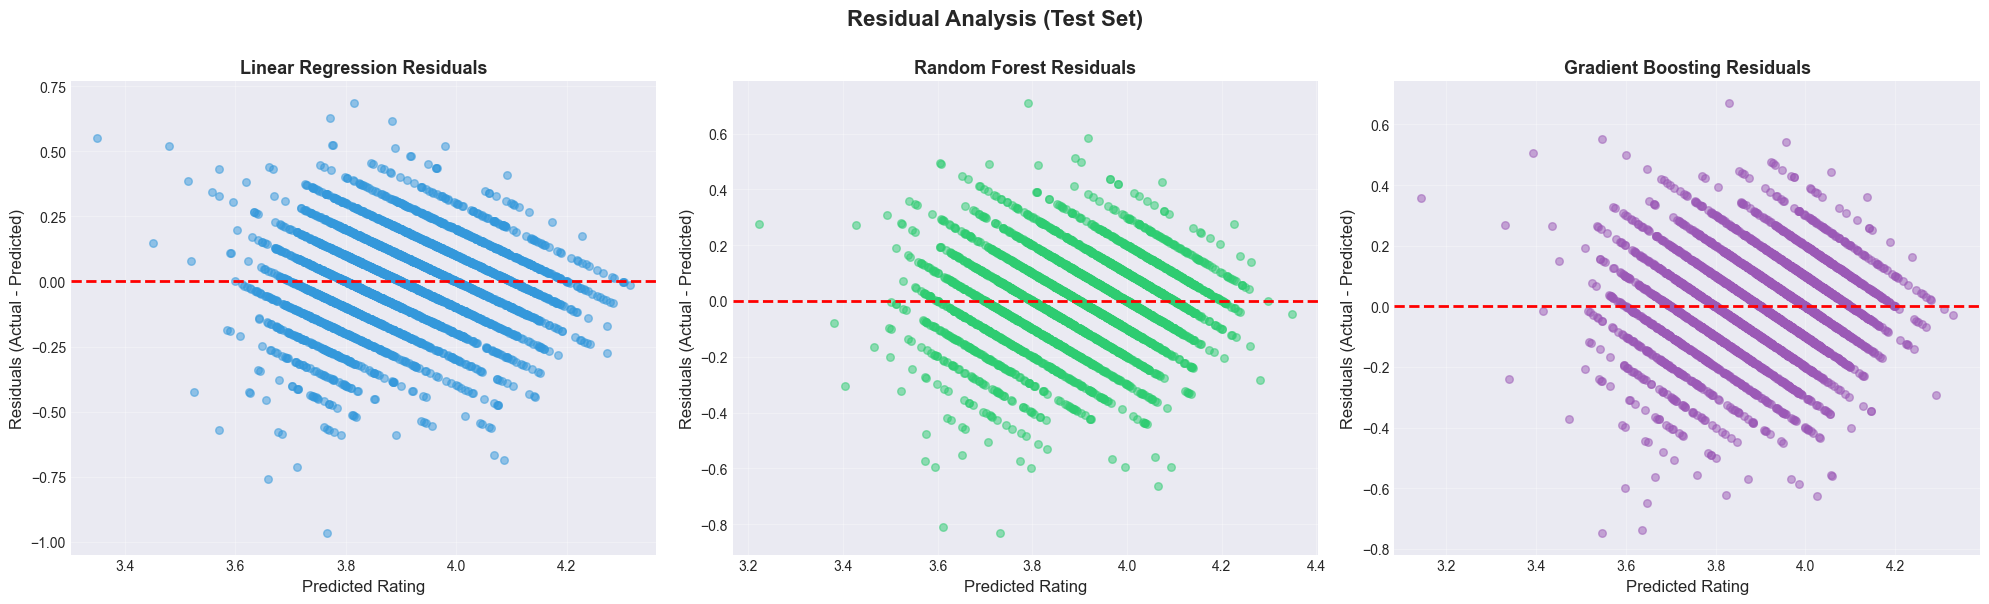

In [34]:
# Residual analysis
residuals_lr = y_test - y_pred_lr_test
residuals_rf = y_test - y_pred_rf_test
residuals_gb = y_test - y_pred_gb_test

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Residual Analysis (Test Set)', fontsize=16, fontweight='bold', y=1.00)

models_residuals = [
    ('Linear Regression', y_pred_lr_test, residuals_lr, '#3498db'),
    ('Random Forest', y_pred_rf_test, residuals_rf, '#2ecc71'),
    ('Gradient Boosting', y_pred_gb_test, residuals_gb, '#9b59b6')
]

for idx, (name, y_pred, residuals, color) in enumerate(models_residuals):
    axes[idx].scatter(y_pred, residuals, alpha=0.5, s=30, color=color)
    axes[idx].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[idx].set_xlabel('Predicted Rating', fontsize=12)
    axes[idx].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
    axes[idx].set_title(f'{name} Residuals', fontsize=13, fontweight='bold')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3.6 Feature Importance Analysis

TOP 20 MOST IMPORTANT FEATURES (Average across RF & GB)


,Feature_Clean,RF_Importance,GB_Importance,Avg_Importance
1,price,0.474808,0.595089,0.534948
3,intensity,0.098587,0.076362,0.087475
2,acidity,0.086514,0.057023,0.071769
4,sweetness,0.091277,0.052176,0.071727
5,tannin,0.071489,0.037325,0.054407
0,vintage,0.037731,0.054527,0.046129
6,age,0.049118,0.036969,0.043043
59,flavor_rank3_earth,0.006475,0.005062,0.005768
36,flavor_rank1_oak,0.004343,0.006058,0.005201
65,flavor_rank3_red_fruit,0.005423,0.004705,0.005064


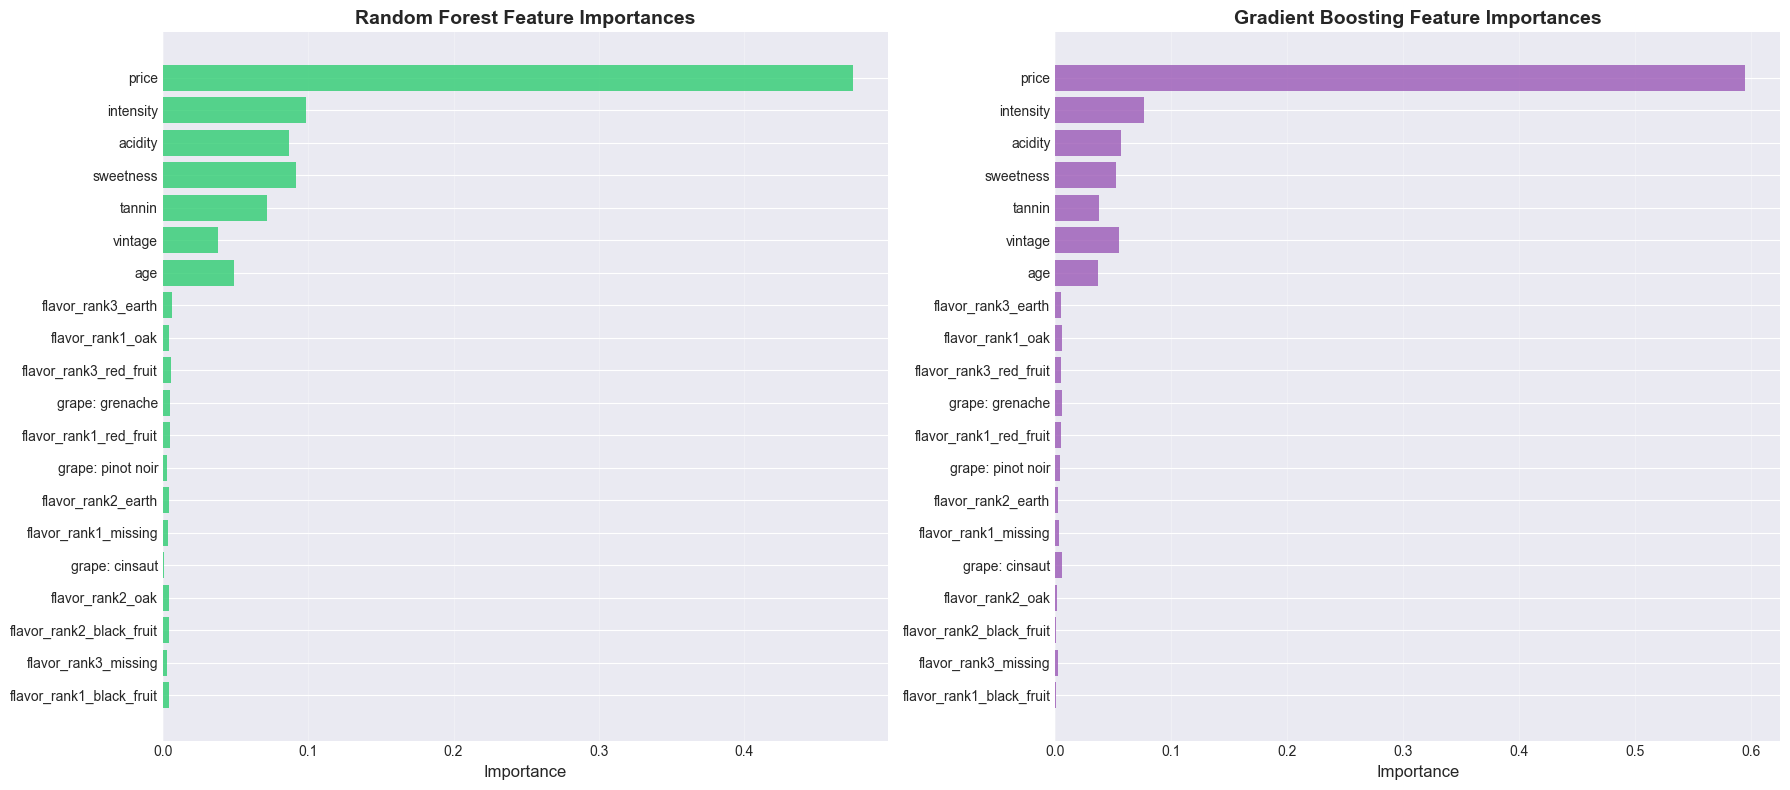


FEATURE IMPORTANCE BY TYPE

Type                        Random Forest    Gradient Boosting
----------------------------------------------------------------------
Numeric                    0.9095 ( 91.0%)       0.9095 ( 90.9%)
Categorical                0.0654 (  6.5%)       0.0556 (  5.6%)
Grape                      0.0250 (  2.5%)       0.0349 (  3.5%)


In [35]:
# Extract and compare feature importances from Random Forest and Gradient Boosting
try:
    feature_names = preprocessor.get_feature_names_out()
    
    # Random Forest importances
    rf_importances = rf_model.feature_importances_
    
    # Gradient Boosting importances
    gb_importances = gb_model.feature_importances_
    
    # Create comparison DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'RF_Importance': rf_importances,
        'GB_Importance': gb_importances
    })
    
    # Average importance across both models
    importance_df['Avg_Importance'] = (importance_df['RF_Importance'] + importance_df['GB_Importance']) / 2
    importance_df = importance_df.sort_values('Avg_Importance', ascending=False)
    
    # Clean feature names for better readability
    importance_df['Feature_Clean'] = importance_df['Feature'].str.replace('num__', '').str.replace('cat__', '').str.replace('grapes__', 'grape: ')
    
    # Top 20 features
    top_features = importance_df.head(20)
    
    print("="*70)
    print("TOP 20 MOST IMPORTANT FEATURES (Average across RF & GB)")
    print("="*70)
    display(top_features[['Feature_Clean', 'RF_Importance', 'GB_Importance', 'Avg_Importance']])
    
    # Visualize top features comparison
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Random Forest
    axes[0].barh(range(len(top_features)), top_features['RF_Importance'], color='#2ecc71', alpha=0.8)
    axes[0].set_yticks(range(len(top_features)))
    axes[0].set_yticklabels(top_features['Feature_Clean'])
    axes[0].set_xlabel('Importance', fontsize=12)
    axes[0].set_title('Random Forest Feature Importances', fontsize=14, fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(alpha=0.3, axis='x')
    
    # Gradient Boosting
    axes[1].barh(range(len(top_features)), top_features['GB_Importance'], color='#9b59b6', alpha=0.8)
    axes[1].set_yticks(range(len(top_features)))
    axes[1].set_yticklabels(top_features['Feature_Clean'])
    axes[1].set_xlabel('Importance', fontsize=12)
    axes[1].set_title('Gradient Boosting Feature Importances', fontsize=14, fontweight='bold')
    axes[1].invert_yaxis()
    axes[1].grid(alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # Summary by feature type
    importance_df['Type'] = importance_df['Feature'].apply(
        lambda x: 'Numeric' if x.startswith('num__') 
        else ('Grape' if x.startswith('grapes__') else 'Categorical')
    )
    
    type_importance_rf = importance_df.groupby('Type')['RF_Importance'].sum().sort_values(ascending=False)
    type_importance_gb = importance_df.groupby('Type')['GB_Importance'].sum().sort_values(ascending=False)
    
    print("\n" + "="*70)
    print("FEATURE IMPORTANCE BY TYPE")
    print("="*70)
    print(f"\n{'Type':<20} {'Random Forest':>20} {'Gradient Boosting':>20}")
    print("-" * 70)
    for feat_type in type_importance_rf.index:
        rf_imp = type_importance_rf[feat_type]
        gb_imp = type_importance_gb[feat_type]
        print(f"{feat_type:<20} {rf_imp:>12.4f} ({rf_imp/type_importance_rf.sum()*100:>5.1f}%) "
              f"{gb_imp:>12.4f} ({gb_imp/type_importance_gb.sum()*100:>5.1f}%)")
    
except Exception as e:
    print(f"Could not extract feature importances: {e}")